Dataset shape: (10000, 8)
    Education     Skills  Years_Experience Certifications  Test_Score  \
0         PhD  65.806026                12             No   68.647407   
1  Bachelor's  49.564307                 8            Yes   73.597282   
2         PhD  47.695599                 6            Yes   65.832617   
3         PhD  41.364857                 0            Yes   69.632823   
4  Bachelor's  79.494367                 9            Yes   87.911456   

   Interview_Rating  Gender  Selection_Status  
0                 4    Male                 0  
1                 4    Male                 0  
2                 3  Female                 0  
3                 5  Female                 0  
4                 3    Male                 0  
Logistic Regression: {'Accuracy': 0.9375, 'Precision': 0.6890756302521008, 'Recall': 0.4823529411764706, 'F1-Score': 0.5674740484429066}
Decision Tree: {'Accuracy': 0.987, 'Precision': 0.9235294117647059, 'Recall': 0.9235294117647059, 'F1-Score': 

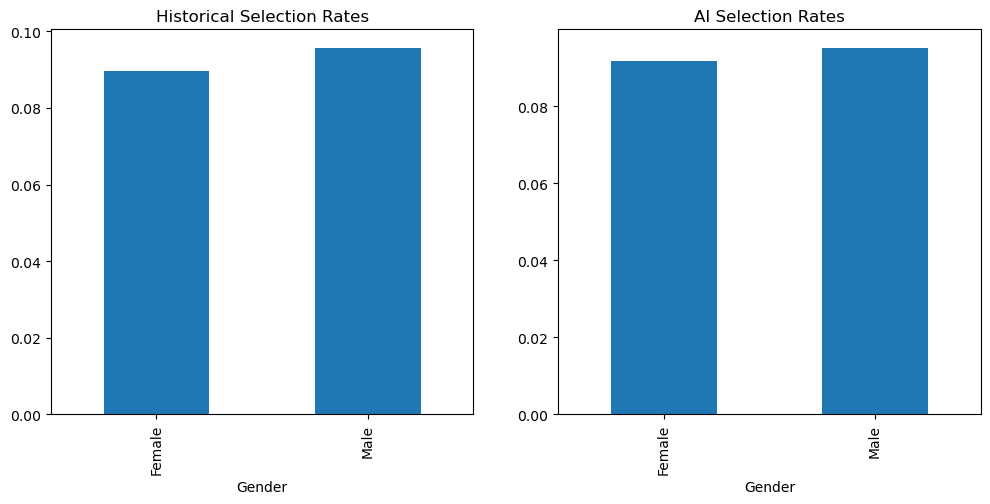

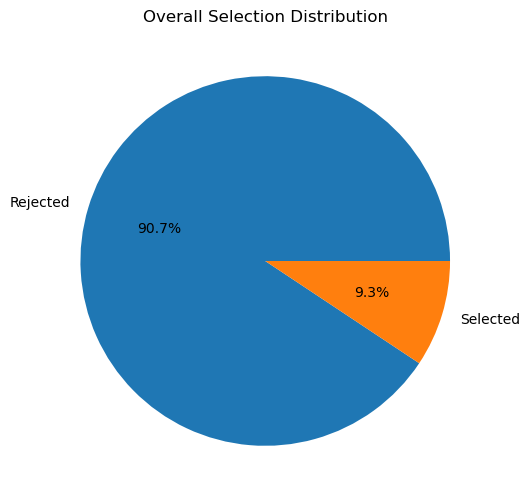

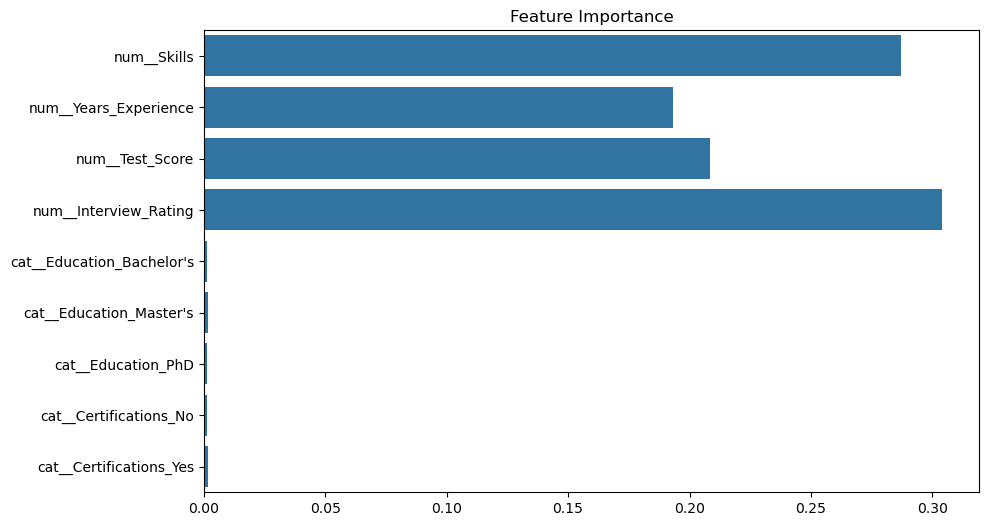

Top 10 Ranked Candidates (Merit-Based):
       Education     Skills  Years_Experience  Merit_Score
4298    Master's  89.183139                 8          1.0
2081    Master's  81.604560                 9          1.0
3272  Bachelor's  93.442836                 9          1.0
8141         PhD  76.565019                18          1.0
9988         PhD  80.070993                15          1.0
5805    Master's  80.737507                11          1.0
420          PhD  80.722236                17          1.0
5164    Master's  85.416994                10          1.0
5803         PhD  86.340391                12          1.0
1918  Bachelor's  81.847867                12          1.0
Bias Reduction: Historical disparity was 0.06296767447939344 AI disparity is 0.03700407808624251


In [1]:
# Cell 1: Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Cell 2: Generate Synthetic Dataset
np.random.seed(42)
n = 10000
data = {
    'Education': np.random.choice(['Bachelor\'s', 'Master\'s', 'PhD'], n),
    'Skills': np.random.normal(70, 15, n).clip(0, 100),
    'Years_Experience': np.random.randint(0, 21, n),
    'Certifications': np.random.choice(['Yes', 'No'], n),
    'Test_Score': np.random.normal(75, 10, n).clip(0, 100),
    'Interview_Rating': np.random.randint(1, 6, n),
    'Gender': np.random.choice(['Male', 'Female'], n, p=[0.6, 0.4])  # Slight imbalance
}
df = pd.DataFrame(data)

# Introduce bias in selection: Females have slightly lower selection rate
df['Selection_Status'] = np.where(
    (df['Skills'] > 70) & (df['Years_Experience'] > 5) & (df['Test_Score'] > 70) & (df['Interview_Rating'] > 3),
    1, 0
)
# Add bias: Reduce selection for females by 10%
female_mask = df['Gender'] == 'Female'
df.loc[female_mask, 'Selection_Status'] = np.where(np.random.rand(sum(female_mask)) < 0.9, df.loc[female_mask, 'Selection_Status'], 0)

print("Dataset shape:", df.shape)
print(df.head())

# Cell 3: Data Preprocessing
# Remove Gender from features
features = ['Education', 'Skills', 'Years_Experience', 'Certifications', 'Test_Score', 'Interview_Rating']
X = df[features]
y = df['Selection_Status']

# Handle missing values (simulate some missing)
X.loc[np.random.choice(X.index, 100, replace=False), 'Skills'] = np.nan
X['Skills'].fillna(X['Skills'].mean(), inplace=True)
# For categorical, use mode if needed, but here no missing.

# Encode and normalize
categorical_features = ['Education', 'Certifications']
numerical_features = ['Skills', 'Years_Experience', 'Test_Score', 'Interview_Rating']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit preprocessor on train
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Cell 4: Train Models
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier()
}

results = {}
for name, model in models.items():
    model.fit(X_train_processed, y_train)
    y_pred = model.predict(X_test_processed)
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred)
    }

# Print results
for name, metrics in results.items():
    print(f"{name}: {metrics}")

# Cell 5: Bias Detection
# Selection rates by gender
gender_selection = df.groupby('Gender')['Selection_Status'].mean()
print("Historical Selection Rates by Gender:")
print(gender_selection)

# Fairness metrics (Demographic Parity: Selection rate difference)
male_rate = gender_selection['Male']
female_rate = gender_selection['Female']
disparate_impact = female_rate / male_rate if male_rate > 0 else 0
print(f"Disparate Impact (Female/Male): {disparate_impact}")

# After AI: Predict on full data without gender
X_full_processed = preprocessor.transform(X)
ai_predictions = models['Random Forest'].predict(X_full_processed)
df['AI_Selection'] = ai_predictions
ai_gender_selection = df.groupby('Gender')['AI_Selection'].mean()
print("AI Selection Rates by Gender:")
print(ai_gender_selection)

# Cell 6: Visualizations
# Bar chart: Selection rates before and after
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
gender_selection.plot(kind='bar', ax=ax[0], title='Historical Selection Rates')
ai_gender_selection.plot(kind='bar', ax=ax[1], title='AI Selection Rates')
plt.show()

# Pie chart: Selected vs Rejected overall
selected_count = df['Selection_Status'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(selected_count, labels=['Rejected', 'Selected'], autopct='%1.1f%%')
plt.title('Overall Selection Distribution')
plt.show()

# Feature importance (Random Forest)
rf_model = models['Random Forest']
feature_names = preprocessor.get_feature_names_out()
importances = rf_model.feature_importances_
plt.figure(figsize=(10,6))
sns.barplot(x=importances, y=feature_names)
plt.title('Feature Importance')
plt.show()

# Cell 7: Output - Rank Candidates
# Rank based on AI predictions (merit-based)
df['Merit_Score'] = rf_model.predict_proba(X_full_processed)[:, 1]  # Probability of selection
ranked_candidates = df.sort_values(by='Merit_Score', ascending=False)
print("Top 10 Ranked Candidates (Merit-Based):")
print(ranked_candidates[['Education', 'Skills', 'Years_Experience', 'Merit_Score']].head(10))

print("Bias Reduction: Historical disparity was", 1 - disparate_impact, "AI disparity is", 1 - (ai_gender_selection['Female'] / ai_gender_selection['Male']))

# Optional: Save dataset
df.to_csv('synthetic_data.csv', index=False)